In [1]:
import utils.mnist_reader as mnist_reader
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA



seed = 0
np.random.seed(seed) 

Load Fashin-MNIST dataset

In [2]:
X, y = mnist_reader.load_mnist('data/fashion', kind='train')
X_te, y_te = mnist_reader.load_mnist('data/fashion', kind='t10k')

## Tune Hyperparameters

To ensure the kNN classifier to have a good performance in predicting new datapoints on the Fashion-MNIST. The first step is to focus on tuning the hyperparameters of the kNN classifier, ensure the model could have a optimal accuracies in predicting new datapoints. In here, we will specifically focus on tuning the number of neighbors and the distance metric used for calculating distances between datapoints. To avoid potential data leakage or overfitting when tuning the hyperparameter. We will split a 25% data from the training set as validation set for tuning purposes, and holdout the testing set for final evaluation.

In [4]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed, shuffle=True)

In [5]:
print(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)

(45000, 784) (15000, 784) (45000,) (15000,)


In [6]:
scaler = StandardScaler()
scaler.fit(X)

X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

In [7]:
X_te.shape

(10000, 784)

Calculate kNN accuracies with different k-vals and metrics. We will use the first 15000 datapoints

In [8]:
param_grid = {
    'n_neighbors': np.arange(3, 11),
    'leaf_size': np.arange(10, 50, 5),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}


n = 15000  # training datasize

clf = KNeighborsClassifier()
search = RandomizedSearchCV(clf, param_grid, n_jobs=-1)
search.fit(X_tr[:n], y_tr[:n])

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'leaf_size': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']})

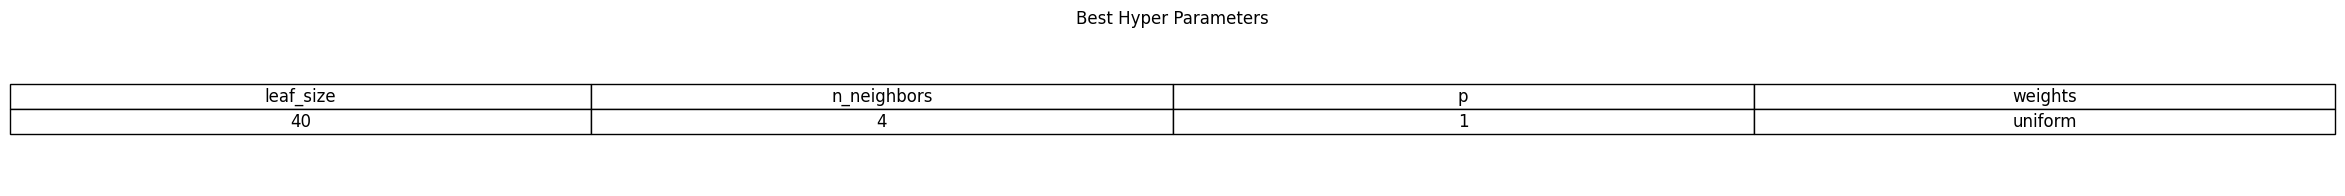

Best Accuracy Score: 0.8400666666666666


In [9]:
# get the best parameters and score
best_params = search.best_params_
best_score = search.best_score_


# Create the table to display the results
fig, ax = plt.subplots(figsize=(20, 2))
ax.axis('off')

table_data = [str(best_params), str(best_score)]

parameter_names = sorted(list(best_params.keys()))
parameter_values = [best_params[key] for key in parameter_names]

table = ax.table(cellText=[parameter_values], colLabels=parameter_names, cellLoc='center', loc='center')

# Set the table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title('Best Hyper Parameters')
plt.show()

print(f'Best Accuracy Score: {best_score}')

Based on the table for the first 15000 training datapoints. The classifier has the best accuracy score when k=7 with distance metric manhattan (p=1), and having leaf size of 15 with distance weights. We will continue using these hyperparameter to evaluate our model performance on the test dataset

In [10]:
print(best_params)

{'weights': 'uniform', 'p': 1, 'n_neighbors': 4, 'leaf_size': 40}


## Confusion Matrix and Ranking-based Metrics

Now, we will plot the confusion matrix to visualize the performance of the kNN classifier on Fashin MNIST dataset. The confusion matrix could help to visualize what labels are being correctly or incorrectly predicted.

We evaluate it on the validation dataset.

The kNN Classifier Has Accuracy (train): 0.9077333333333333
The kNN Classifier Has Accuracy (validation): 0.8579333333333333
The kNN Classifier Has Accuracy (testing): 0.8549


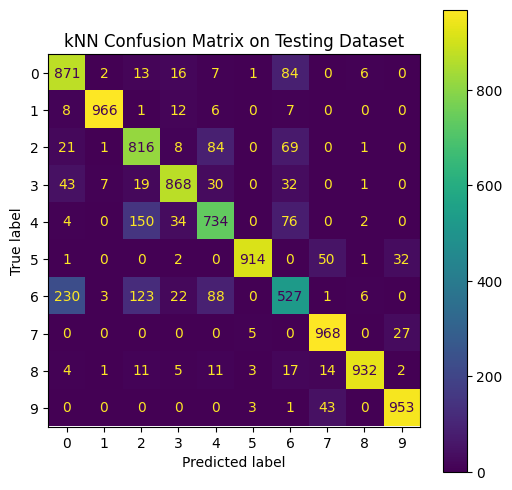

In [11]:
figure, axes = plt.subplots(figsize=(6, 6))

clf = KNeighborsClassifier(**best_params, n_jobs=-1)
clf.fit(X_tr, y_tr)

y_tr_pred = clf.predict(X_tr)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_te)

# plot confusion matrix
axes.set_title("kNN Confusion Matrix on Testing Dataset")
cm = confusion_matrix(y_te, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(ax=axes)

acc_tr = accuracy_score(y_tr, y_tr_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_te = accuracy_score(y_te, y_test_pred)

print(f"The kNN Classifier Has Accuracy (train): {acc_tr}")
print(f"The kNN Classifier Has Accuracy (validation): {acc_val}")
print(f"The kNN Classifier Has Accuracy (testing): {acc_te}")

<Axes: >

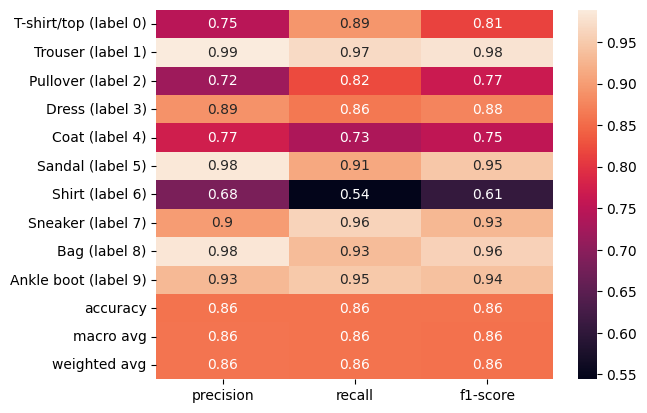

In [12]:


label2desc = {0: 'T-shirt/top (label 0)', 
              1: 'Trouser (label 1)', 
              2: 'Pullover (label 2)', 
              3: 'Dress (label 3)', 
              4: 'Coat (label 4)', 
              5: 'Sandal (label 5)', 
              6: 'Shirt (label 6)', 
              7: 'Sneaker (label 7)',
              8: 'Bag (label 8)',
              9: 'Ankle boot (label 9)'}



report = classification_report(y_val, y_val_pred, target_names = label2desc.values(), output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)


Referring to the confusion matrix, row 6 column 0, a off-diagonal cell that can be considered as error, has the highest counts. This means that 252 datapoints that were actually labeled as Shirt (label 6) but were predicted as T-shirt/top (label 0), suggesting that the classifier often confuses Shirts with T-shirts/tops.

Furthemore, referring to the heatmap.Shirt (label 6) has the lowest precision and recall. Since precision measures the likelihood of correctly classifying the positive prediction, recall measures the proportion of true positive that are correctly classified. This means that if the classifier predicts the datapoint as Shirt, it is correct only 67% of time. Additionally, among all the datapoint that are actually Shirts, the classifier could only identified 60% of them as Shirt. Ultimately, looking at the f1-score, which combines and balances both precision and recall scores, illustrates that the classfier has the lowest accuracy in predicting Shirts, followed by Coat (label 4) with an F1-score of 0.76 and Pullover (label 2) with an F1-score of 0.77.

<b> Hypothesis on why the classifier has lowest accuracy in predictying shirts: </b> One hypothesis is that the features, which are the pixel values of the images, for Shirts are similar to certain other clothing categories in the dataset. Since kNN classifier classify new datapoint by estimating the majority labels of the k nearest training data, similar visual patterns would indicate that the feature vectors of these labels are close to one another. This will increase the likelihood of the kNN classifier to assign the new feature vectors to wrong labels. For instance, Shirts and T-shirts/tops can exhibit the same visual patterns, which makes the classifier often confuses Shirts with T-shirts as previously discussed on the confusion matrix. Similarly, other labels such as Dress (label 3), Coat (label 4), and Pullover (label 2) also exhibit lower accuracy (<0.9 F1-score) as they also have similar visual patterns

## Leaning Curves
TODO: description

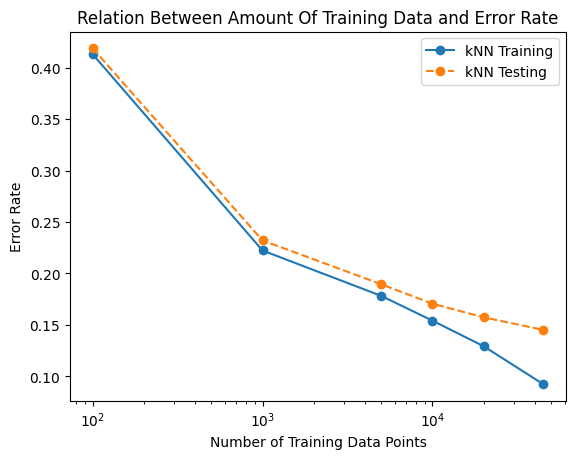

In [13]:
n_tr = [100, 1000, 5000, 10000, 20000, 45000]

tr_errors = []
te_errors = []

for n in n_tr:
    clf = KNeighborsClassifier(**best_params, n_jobs=-1)
    clf.fit(X_tr[:n], y_tr[:n])

    # compute training error and testing error
    y_tr_pred = clf.predict(X_tr)
    tr_errors.append(1 - accuracy_score(y_tr, y_tr_pred))

    y_te_pred = clf.predict(X_te)
    te_errors.append(1 - accuracy_score(y_te, y_te_pred))


plt.figure()
plt.plot(n_tr, tr_errors, 'o-', label='kNN Training')
plt.plot(n_tr, te_errors, 'o--', label='kNN Testing')

plt.xlabel('Number of Training Data Points')
plt.ylabel('Error Rate')
plt.xscale('log')
plt.title('Relation Between Amount Of Training Data and Error Rate')

plt.legend()
plt.show()

## Interpretability
Investigate which features the model is relying on